<a href="https://colab.research.google.com/github/Farhanudin1/deep-learning/blob/main/CNN%20add%20Models%20Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
ls

 3pesti/              dataset2/            'Temperature & Humidity'/   Untitled0.ipynb
'Bacterial Blight'/  'False Smut'/          tes_gambar_tungau.jpeg    'VIRUS TUNGRO'/
 Blast/               Healthy_Images/       tes_gambar_ulat.jpeg       yolov5s.pt
'Brown Leaf Spot'/    KERACUNAN ZAT BESI/   test_gambar.jpeg
 dataset1/            Ricesheath/           Unhealthy_Images/


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import display, HTML

In [ ]:
sdir=r'3pest'

filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                 filepaths  labels
0   3pest/aphids/jpg_4.jpg  aphids
1  3pest/aphids/jpg_11.jpg  aphids
2  3pest/aphids/jpg_15.jpg  aphids
3  3pest/aphids/jpg_45.jpg  aphids
4  3pest/aphids/jpg_25.jpg  aphids
labels
aphids      50
mites       50
armyworm    50
Name: count, dtype: int64


In [ ]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  120   test_df length:  15   valid_df length:  15


In [ ]:
height=128
width=128
channels=3
batch_size=64

img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

gen=ImageDataGenerator(
    rescale=1./255,
    )
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

validgen=ImageDataGenerator(rescale=1./255)
valid_gen=validgen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)

testgen=ImageDataGenerator(rescale=1./255)
test_gen=testgen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)

test batch size:  15   test steps:  1
Found 120 validated image filenames belonging to 3 classes.
Found 15 validated image filenames belonging to 3 classes.
Found 15 validated image filenames belonging to 3 classes.
['aphids', 'armyworm', 'mites']


In [ ]:
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

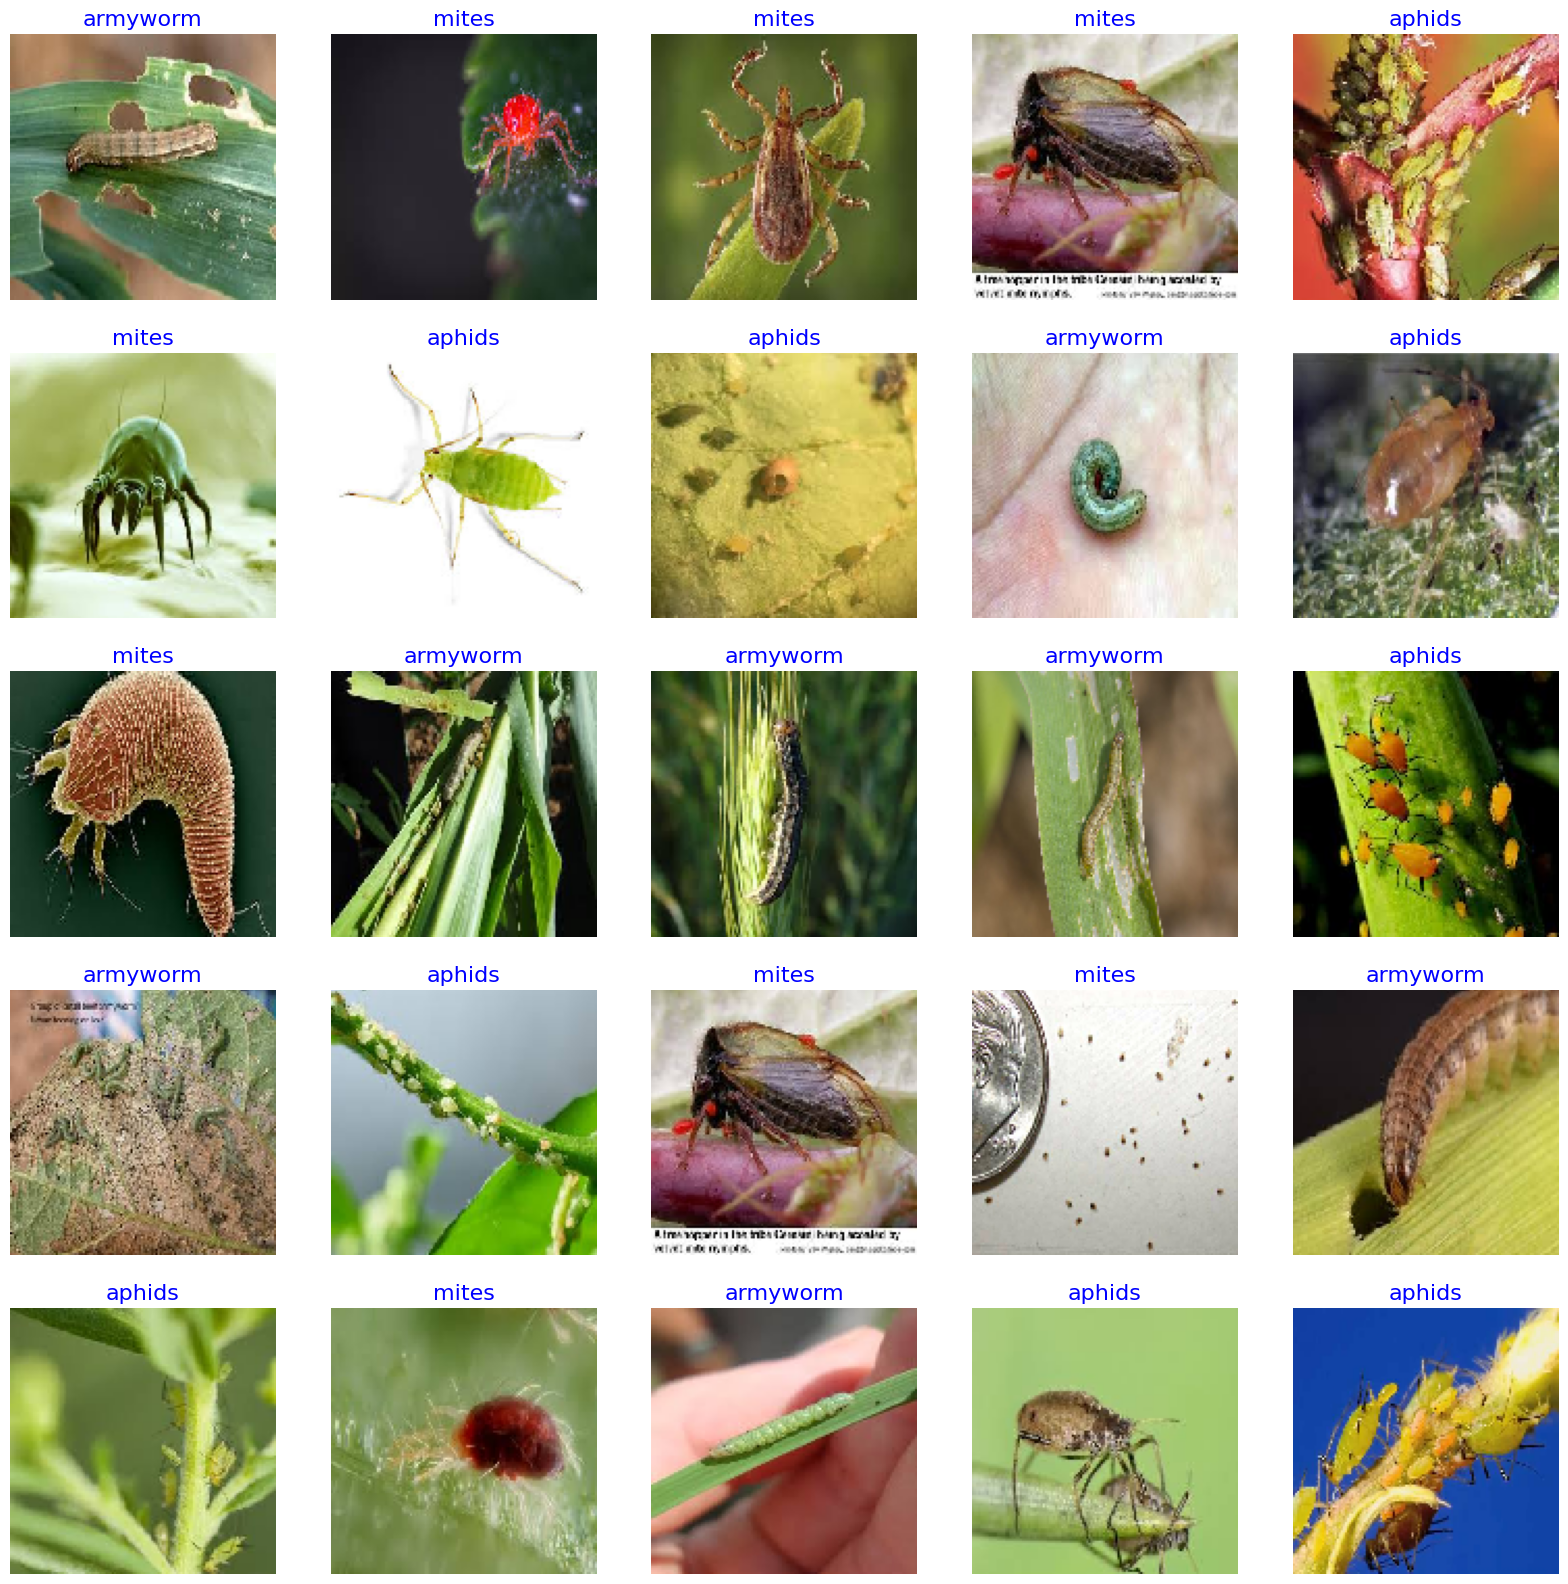

In [ ]:
show_image_samples(train_gen)

In [ ]:
base_model=tf.keras.applications.Xception(include_top=False, weights="imagenet",input_tensor=Input(shape=(128,128,3)))

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 63, 63, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 63, 63, 32)     │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 63, 63, 32)     │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 61, 61, 64)     │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 61, 61, 64)     │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 61, 61, 64)     │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 61, 61, 128)    │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 61, 61, 128)    │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 61, 61, 128)    │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 61, 61, 128)    │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 61, 61, 128)    │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 31, 31, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 31, 31, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [ ]:
base_model.trainable = False

In [ ]:
model_name='Cendekia'
print("Building model with", base_model)
model = tf.keras.Sequential([
            # Note the input shape is the desired size of the image 128x128 with 3 bytes color
            # This is the first convolution
            base_model,
            tf.keras.layers.Conv2D(filters=32, padding='same', kernel_size=3, activation='relu', strides=1),
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
            tf.keras.layers.Dropout(rate=0.5),

            tf.keras.layers.Flatten(),
            # Change the output layer to have 3 units (matching the number of classes)
            tf.keras.layers.Dense(3, activation='softmax') # Changed from 2 to 3
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001),
              loss='categorical_crossentropy',
              metrics=['accuracy']) # Changed 'accuracy' to ['accuracy']

Building model with <Functional name=xception, built=True>


In [ ]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 4, 4, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 4, 4, 32)            │         589,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 2, 2, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,451,723 (81.83 MB)

 Trainable params: 590,243 (2.25 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
epochs =10

history=model.fit(x=train_gen, epochs=epochs, validation_data=valid_gen)

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 6s/step - accuracy: 0.9785 - loss: 0.0603 - val_accuracy: 1.0000 - val_loss: 0.0144
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 5s/step - accuracy: 0.9659 - loss: 0.0797 - val_accuracy: 1.0000 - val_loss: 0.0129
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 6s/step - accuracy: 0.9829 - loss: 0.0495 - val_accuracy: 1.0000 - val_loss: 0.0118
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 6s/step - accuracy: 0.9829 - loss: 0.0371 - val_accuracy: 1.0000 - val_loss: 0.0111
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 6s/step - accuracy: 0.9944 - loss: 0.0235 - val_accuracy: 1.0000 - val_loss: 0.0101
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 7s/step - accuracy: 0.9837 - loss: 0.0431 - val_accuracy: 1.0000 - val_loss: 0.0095
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step - accuracy: 0.9889 - loss: 0.0367 - val_accuracy: 1.0000 - val_loss: 0.0090
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 8s/step - accuracy: 0.9885 - loss: 0.0412 - val_accuracy: 1.0000 - val_loss: 0.0085
Epoch 9/

In [ ]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout
    #plt.style.use('fivethirtyeight')
    plt.show()

In [ ]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'
    dict_path=os.path.join(save_dir,dict_name)
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)
    errors=0
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors=errors + 1
        y_pred.append(pred_index)
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code
            # This line was not indented correctly
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                split1=os.path.split(error_list[i])
                split2=os.path.split(split1[0])
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]

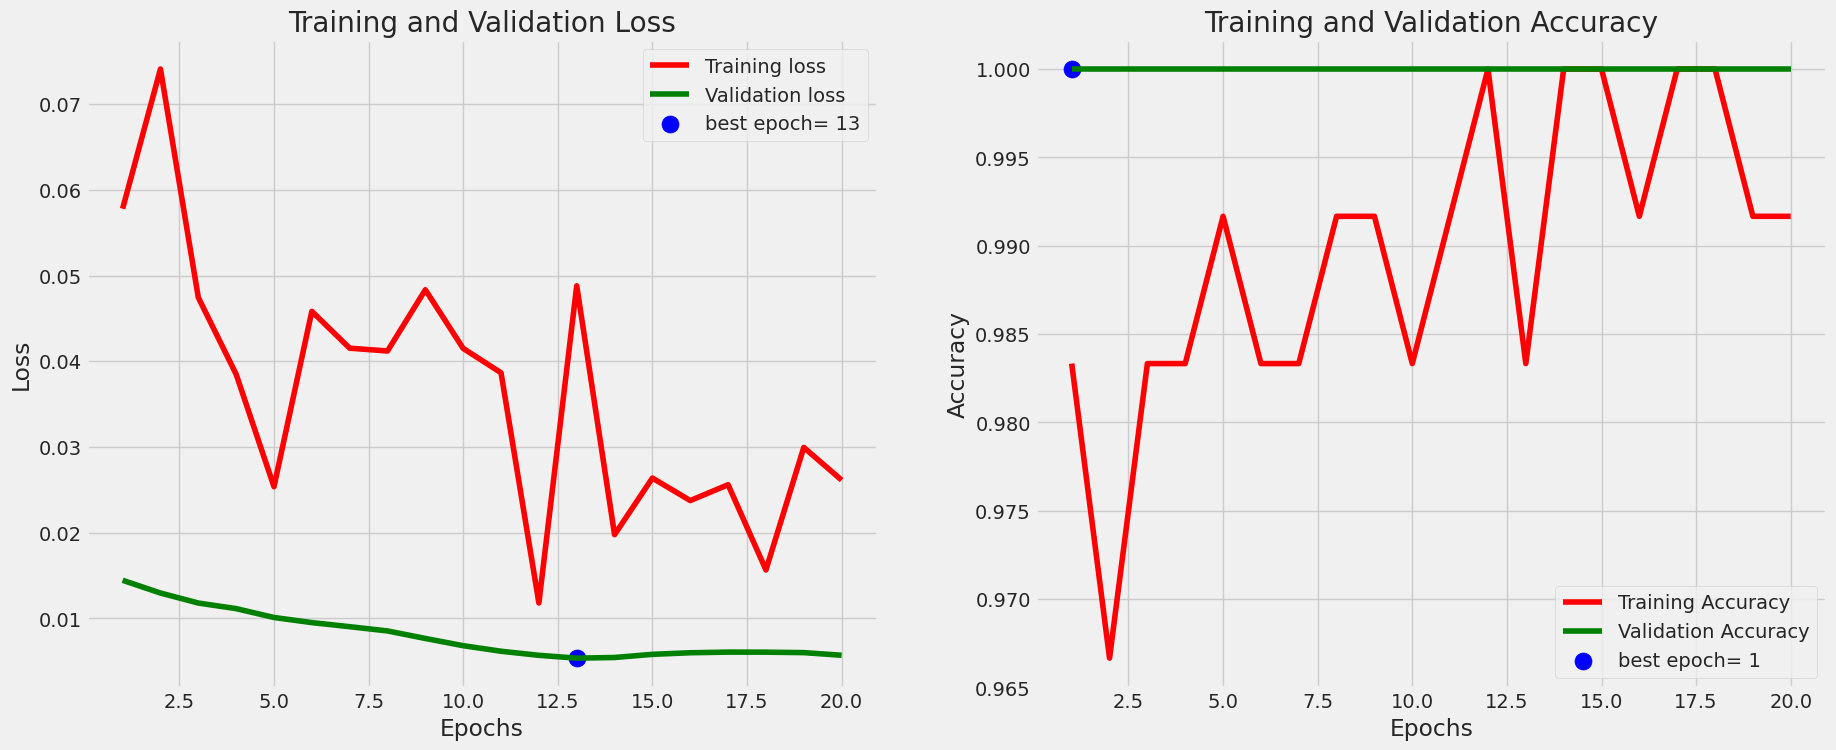

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step - accuracy: 0.9333 - loss: 0.0693


accuracy on the test set is 93.33 %


In [ ]:
from termcolor import colored

def print_in_color(txt_msg,fore_tupple,back_tupple):
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}'
    mat='\033[38;2;{0};{1};{2};48;2;{3};{4};{5}m'.format(rf,gf,bf,rb,gb,bb)
    print(mat + msg .format(txt_msg) + '\033[0m')

tr_plot(history,0)
save_dir=r'./'
subject='pest'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80)) # This line was causing the error
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


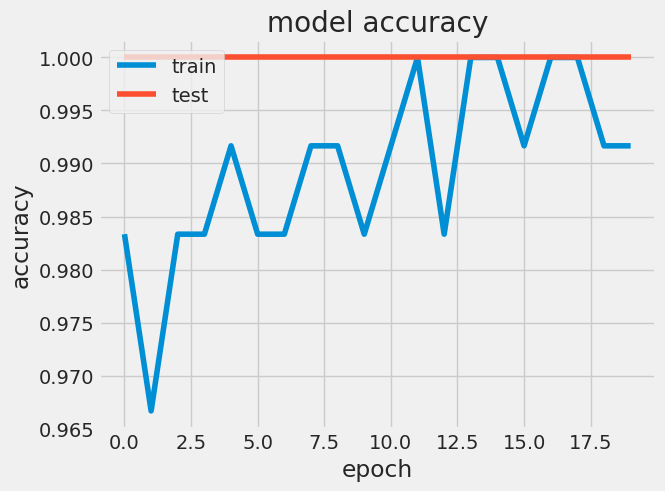

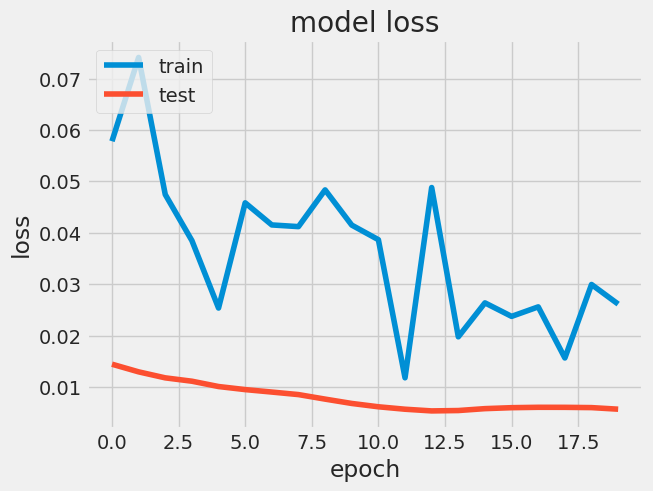

In [ ]:
import matplotlib.pyplot as plt

print(history.history.keys()) # Changed H to history
# summarize history for accuracy
plt.plot(history.history['accuracy']) # Changed H to history
plt.plot(history.history['val_accuracy']) # Changed H to history
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss']) # Changed H to history
plt.plot(history.history['val_loss']) # Changed H to history
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
print_code=0
preds=model.predict(test_gen)
print_info( test_gen, preds, print_code, save_dir, subject )

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [ ]:
# ... previous code ...

print_code = 0
preds = model.predict(test_gen)
print_info(test_gen, preds, print_code, save_dir, subject)

# Prepare your test data (testX and testY) here
# Example: Assuming you have a DataFrame called 'test_df'
# with columns 'filepaths' and 'labels':

from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import img_to_array, load_img

testX = []
testY = []

for index, row in test_df.iterrows():
    image_path = row['filepaths']
    image = load_img(image_path, target_size=(128, 128))  # Adjust target_size if needed
    image = img_to_array(image) / 255.0  # Normalize pixel values
    testX.append(image)
    testY.append(row['labels'])

testX = np.array(testX)

lb = LabelBinarizer()
testY = lb.fit_transform(testY)

# Now you can evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
                            predictions.argmax(axis=1), target_names=lb.classes_))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[INFO] evaluating network...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
              precision    recall  f1-score   support

      aphids       1.00      0.80      0.89         5
    armyworm       1.00      1.00      1.00         7
       mites       0.75      1.00      0.86         3

    accuracy                           0.93        15
   macro avg       0.92      0.93      0.92        15
weighted avg       0.95      0.93      0.93        15



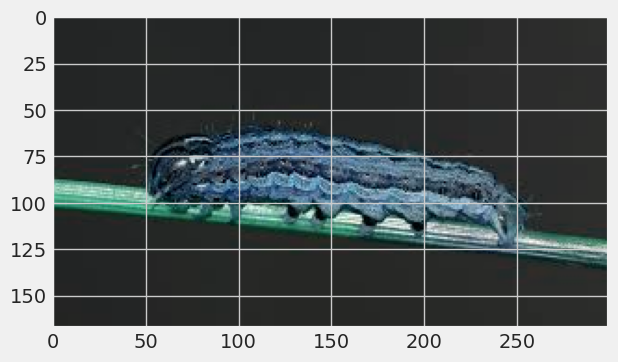

In [ ]:
import cv2
import matplotlib.pyplot as plt

gambar = 'tes_gambar_ulat.jpeg'
image = cv2.imread(gambar)
plt.imshow(image)
plt.show()

In [ ]:
!pip install Pillow # Install PIL if you haven't already
from PIL import Image # Import the Image class from PIL

gambar = 'tes_gambar_ulat.jpeg'
image_test = Image.open(gambar) # Now you can use Image.open
image_test = np.array(image_test.resize((128, 128))) / 255.0
image_test.shape

(128, 128, 3)

In [ ]:
image_test=np.expand_dims(image_test, axis=0)
image_test.shape

(1, 128, 128, 3)

In [ ]:
predict = model.predict(image_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [ ]:
print(predict)

[[6.021664e-07 9.999989e-01 4.955894e-07]]


In [ ]:
print(lb.classes_[predict.argmax(axis=1)])

['armyworm']
